In [9]:
#Library declaration
import numpy as np
import cv2 as cv 
import matplotlib.pyplot as plt
import h5py
import math
import os
from scipy import signal

In [10]:
def vizualise_spikes(spikes , samplingtime , data):
    a = np.zeros(data.shape)    
    for i in spikes[0][:]:
        index = int((i / samplingtime))
        if index > data.shape[1]:
            return a
        else :    
            a[0][index] = data[0][index]
    return a

def find_largest(limit , spikes):
    previous = 0
    for i in spikes[0][:]:
        previous = previous + 1
        if i > limit: 
            return int(previous)

def bit_shift_mult(a,b):
    output = np.zeros(a.shape)
    for i in range(0,a.shape[0]):
        if b[i]==0:
            coeff = 0
        else:
            coeff = len(bin(b[i]))-2    
        output[i] = a[i]*(2**(coeff))        
    return output            
        

0.041666666666666664
0.13888888888888887
0.13888888888888887
16


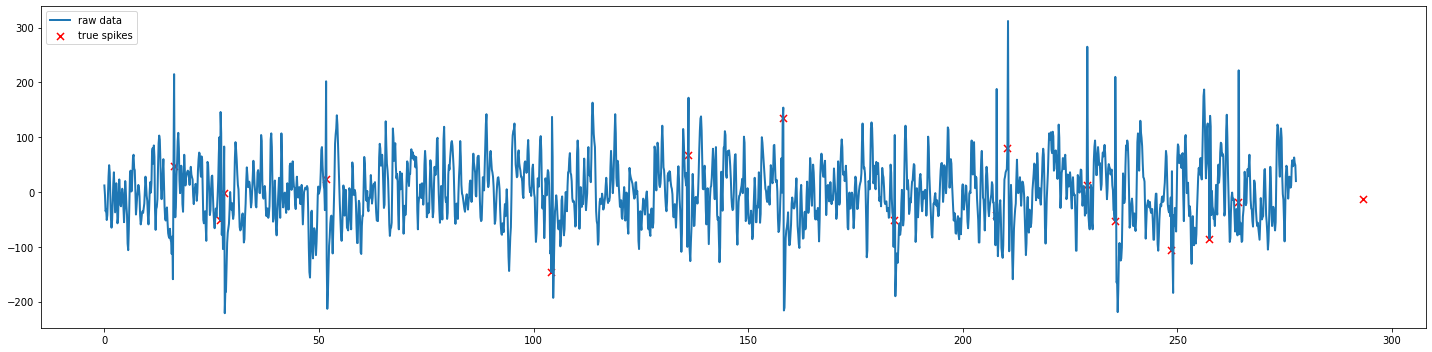

(432000,)
<class 'int'>
465
-473


In [3]:
#reading test data for .mat file provided by Zheng Zhang

test_folder = 'raw_data/'
test_file = "C_Difficult1_noise02"
test_file_type = '.h5'

# reading the data
test_filename = test_folder + test_file + test_file_type
with h5py.File(test_filename,'r') as read_test_file:
    data = read_test_file['data'][()] # the raw waveform
    sampling_rate = read_test_file['samplingIntervar'][()]
    spikes = read_test_file['spike_times'][()] # the spike time points

spikes = np.transpose(spikes)
spikes = spikes +18
data = np.transpose(data)
data = data[0][:]
print(sampling_rate[0][0])
sampling_rate = sampling_rate[0][0]
# uncomment the next few lines if downsampling is required


data = signal.resample_poly(data,up=3,down=10)
spikes = spikes*3/10
spikes = np.round(spikes , 0)
sampling_rate= sampling_rate*10.0
sampling_rate = sampling_rate/3.0
print(sampling_rate)
#fixed point implementation
data = data * 256
data = np.round(data,0)
data = data.astype(int)


print(sampling_rate)
spikes_int = spikes.astype(int)
time = np.linspace(0,sampling_rate*data.shape[0], num=data.shape[0])
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
limit  = 2000
ax.plot(time[0:limit],data[0:limit],linewidth=2.0 , label = 'raw data')
largest_spike_index = find_largest(limit, spikes)
print(largest_spike_index)
ax.scatter(time[(spikes_int[0][0:largest_spike_index])],data[(spikes_int[0][0:largest_spike_index])], s=50, c='r', marker='x' , label = 'true spikes')
plt.legend(loc = 'upper left')
fig.tight_layout()
plt.show()

data_size = data.shape
data_size = data_size[0]
print(data.shape)
print(type(data_size))
print(np.amax(data))
print(np.amin(data))

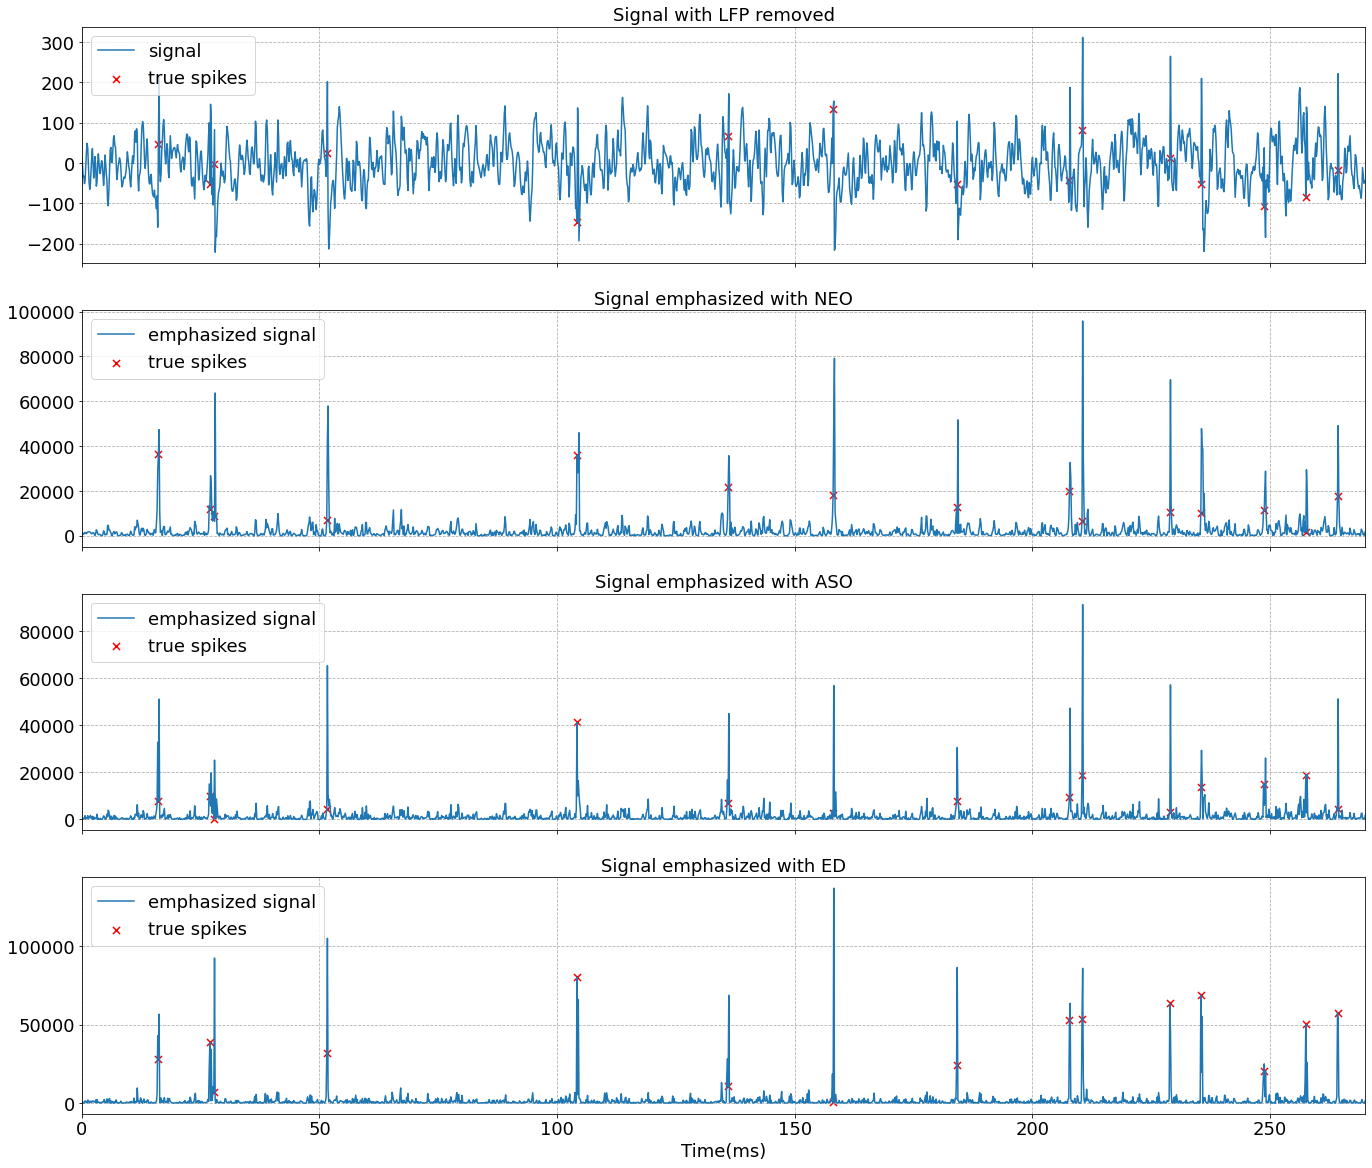

In [11]:
class DemoException(Exception):
    def __init__(self, message):
        super().__init__(message)


def emphasizer(data , method):
    data_size = data.shape
    data_size = data_size[0]
    if data_size < 1:
        raise DemoException('data size is invalid')
    if  method not in ['neo', 'fneo' , 'aso','ed','absolute']:
        raise DemoException('method is invalid')
    zeros = np.array([0 , 0])
    data_shifted_up = np.hstack((zeros, data))
    data_shifted_down = np.hstack((data , zeros))
    data_appended = np.hstack((0,data))
    data_appended = np.hstack((data_appended,0))
    
    match method:
        case 'neo':
            data_abs = np.abs(data_appended)
            data_sh_down_abs = np.abs(data_shifted_down)
            data_sh_up_abs = np.abs(data_shifted_up)
            output = np.multiply(data_appended,data_appended) - np.multiply(data_shifted_down,data_shifted_up)
            #output = bit_shift_mult(data_abs,data_abs) - np.multiply(data_sh_down_abs,data_sh_up_abs)
        case 'aso':
            slope = np.subtract(data_appended , data_shifted_down)
            slope_abs = np.abs(slope)
            data_abs = np.abs(data_appended)
            #output = bit_shift_mult(slope_abs,data_abs) 
            output = np.multiply(data_appended, slope)
        case 'fneo':  
            output = np.multiply(data_appended,data_appended)
        case 'ed':
            slope = np.subtract(data_appended , data_shifted_down)
            slope_abs = np.abs(slope)
            #output = bit_shift_mult(slope_abs,slope_abs)
            output = np.multiply(slope,slope)
        case 'absolute':
            output = np.abs(data_appended)     
    return output[1:data_size]

data_neo = emphasizer(data,method='neo')
data_neo = np.abs(data_neo)
data_aso = emphasizer(data,method='aso')
data_aso = np.abs(data_aso)
data_fneo = emphasizer(data,method='ed')
data_fneo = np.abs(data_fneo)

num_samples_ploted = 2000
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
fig_emphasizer , ax_emphasizer = plt.subplots(4,sharex=True)
fig_emphasizer.set_size_inches(23,20)
ax_emphasizer[0].plot(time[0:num_samples_ploted],data[0:num_samples_ploted], label = 'signal')
ax_emphasizer[1].plot(time[0:num_samples_ploted],data_neo[0:num_samples_ploted],label = 'emphasized signal')
ax_emphasizer[2].plot(time[0:num_samples_ploted],data_aso[0:num_samples_ploted],label = 'emphasized signal')
ax_emphasizer[3].plot(time[0:num_samples_ploted],data_fneo[0:num_samples_ploted],label = 'emphasized signal')
ax_emphasizer[0].scatter(time[(spikes_int[0][0:largest_spike_index])],data[(spikes_int[0][0:largest_spike_index])], s=50, c='r', marker='x' , label = 'true spikes')
ax_emphasizer[1].scatter(time[(spikes_int[0][0:largest_spike_index])],data_neo[(spikes_int[0][0:largest_spike_index])], s=50, c='r', marker='x' , label = 'true spikes')
ax_emphasizer[2].scatter(time[(spikes_int[0][0:largest_spike_index])],data_aso[(spikes_int[0][0:largest_spike_index])], s=50, c='r', marker='x' , label = 'true spikes')
ax_emphasizer[3].scatter(time[(spikes_int[0][0:largest_spike_index])],data_fneo[(spikes_int[0][0:largest_spike_index])], s=50, c='r', marker='x' , label = 'true spikes')
ax_emphasizer[0].legend(loc = 'upper left')
ax_emphasizer[1].legend(loc = 'upper left') 
ax_emphasizer[2].legend(loc = 'upper left')
ax_emphasizer[3].legend(loc = 'upper left')
ax_emphasizer[0].yaxis.grid(True, linestyle='--')
ax_emphasizer[1].yaxis.grid(True, linestyle='--')
ax_emphasizer[2].yaxis.grid(True, linestyle='--')
ax_emphasizer[3].yaxis.grid(True, linestyle='--')
ax_emphasizer[0].xaxis.grid(True, linestyle='--')
ax_emphasizer[1].xaxis.grid(True, linestyle='--')
ax_emphasizer[2].xaxis.grid(True, linestyle='--')
ax_emphasizer[3].xaxis.grid(True, linestyle='--')
ax_emphasizer[0].set_title('Signal with LFP removed')
ax_emphasizer[1].set_title('Signal emphasized with NEO')
ax_emphasizer[2].set_title('Signal emphasized with ASO')
ax_emphasizer[3].set_title('Signal emphasized with ED')
ax_emphasizer[0].set_xlim(left=0,right=270)
ax_emphasizer[1].set_xlim(left=0,right=270)
ax_emphasizer[2].set_xlim(left=0,right=270)
ax_emphasizer[3].set_xlim(left=0,right=270)
ax_emphasizer[3].set(xlabel='Time(ms)')
plt.savefig('emphasizer.jpg', bbox_inches='tight',dpi=300, pad_inches=0.1)
             

[]

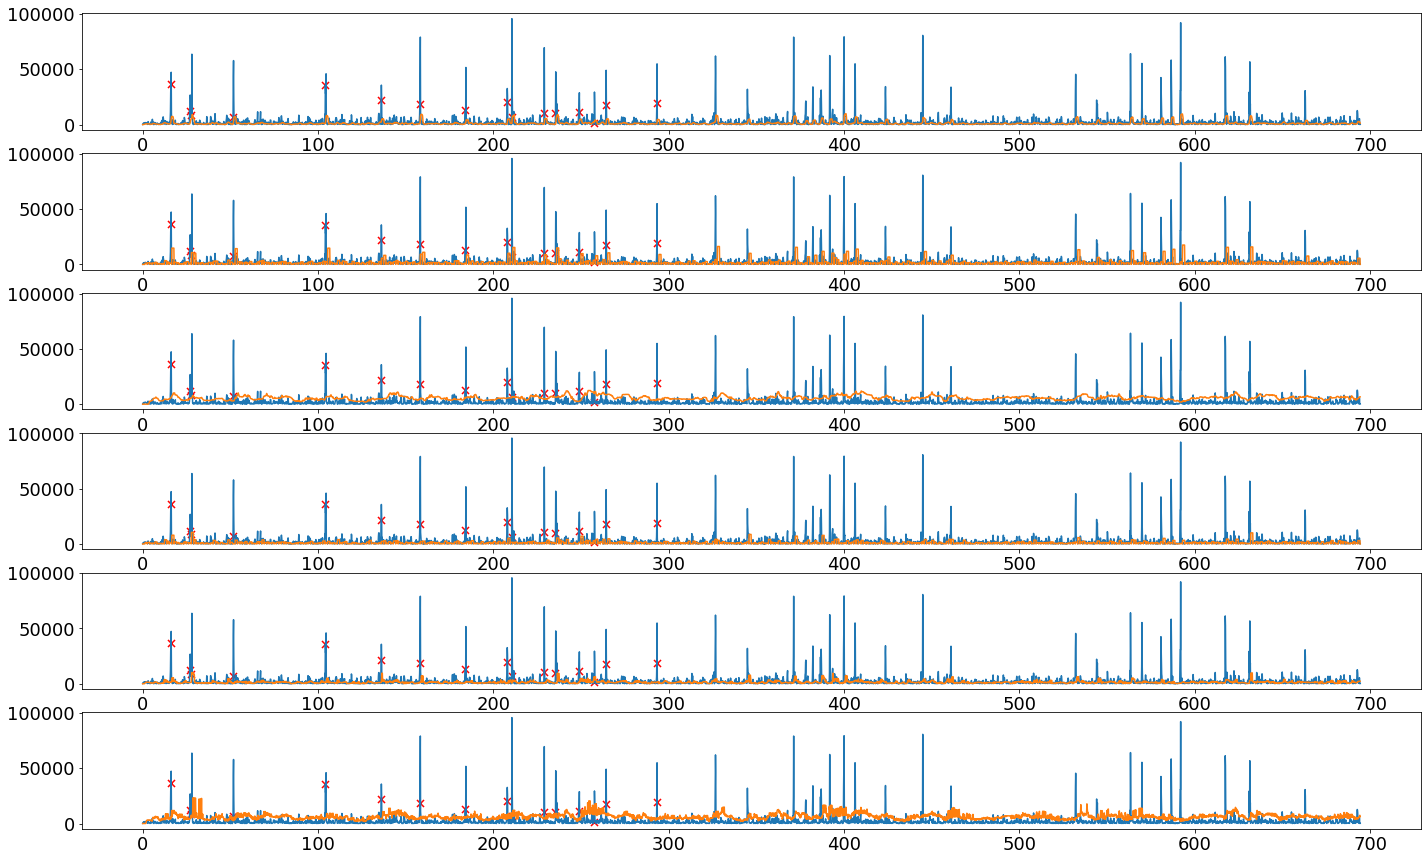

In [12]:
# the following cell contains thresholfin algorithms

def moving_average(data, no_samples, scale):
    data_size = data.shape
    data_size = data_size[0]
    if data_size < 1:
        raise DemoException('data size is invalid')
    if  no_samples < 1 :
        raise DemoException('number of samples is invalid')
    if scale <= 0:  
        raise DemoException('scale is invalid')
    output = np.zeros(data_size)
    zeros = np.zeros(no_samples)
    data_appended = np.hstack((zeros , data) )   
    for i in range((no_samples),(data_size+no_samples)):
        output[i-no_samples] = np.mean(data_appended[(i-no_samples):i])
    return output*scale 

def jumping_average(data, no_samples ,scale, jump , start):
    data_size = data.shape
    data_size = data_size[0]
    if data_size < 1:
        raise DemoException('data size is invalid')
    if  no_samples < 1 :
        raise DemoException('number of samples is invalid')
    if scale <= 0:  
        raise DemoException('scale is invalid')
    output = np.zeros(data_size)
    zeros = np.zeros(no_samples)
    data_appended = np.hstack((zeros , data) )
    i = start
    while i<data_size:
        if i+jump-1 < data_size:
            indices = range(i,(i+jump-1))
        else:
            indices = range(i,data_size)    
        output[indices] = np.mean(data_appended[i:(i+no_samples)])
        i += jump
    return output*scale

def moving_median(data, no_samples, scale):
    data_size = data.shape
    data_size = data_size[0]
    if data_size < 1:
        raise DemoException('data size is invalid')
    if  no_samples < 1 :
        raise DemoException('number of samples is invalid')
    if scale <= 0:  
        raise DemoException('scale is invalid')
    output = np.zeros(data_size)
    zeros = np.zeros(no_samples)
    data_appended = np.hstack((zeros , data))   
    for i in range((no_samples),(data_size+no_samples)):
        output[i-no_samples] = np.median(data_appended[(i-no_samples):i])
    return output*scale

def jumping_median(data, no_samples, scale, jump, start):
    data_size = data.shape
    data_size = data_size[0]
    if data_size < 1:
        raise DemoException('data size is invalid')
    if scale <= 0:  
        raise DemoException('scale is invalid')
    output = np.zeros(data_size)
    zeros = np.zeros(no_samples)
    data_appended = np.hstack((zeros , data))
    i = start
    while i<data_size:
        if i+jump-1 < data_size:
            indices = range(i,(i+jump-1))
        else:
            indices = range(i,data_size)  
        output[indices] = np.median(data_appended[i:(i+no_samples)])
        i += jump
    return output*scale

def median_of_medians(data ,no_datasets , small_samples, scale, jump, offset,start):
    data_size = data.shape
    data_size = data_size[0]
    if data_size < 1:
        raise DemoException('data size is invalid')
    if scale <= 0:  
        raise DemoException('scale is invalid')
    output = np.zeros(data_size)
    zeros = np.zeros(no_datasets*(small_samples+offset))
    medians = np.zeros(no_datasets)
    data_appended = np.hstack((zeros , data))
    i = start + offset
    while i < data_size:
        for j in range(0,(no_datasets)*(small_samples+offset),(small_samples+offset)):
            if (i+(j+small_samples)) < data_size:
                medians[round(j/(small_samples+offset))] = np.median(data_appended[(i+j):(i+j+small_samples)])
            else:
                medians[round(j/round(small_samples+offset))] = np.median(data_appended[(i+j):])
                break
        if i+jump < data_size:
            indices = range(i,(i+jump))
        else:
            indices = range(i,data_size)       
        output[indices] = np.median(medians)
        i += jump
    return output*scale

def median_of_medians_hard(data ,no_datasets , small_samples = 5, scale = 1.0):
    data_size = data.shape
    data_size = data_size[0]
    if data_size < 1:
        raise DemoException('data size is invalid')
    if scale <= 0:  
        raise DemoException('scale is invalid')
    output = np.zeros(data_size)
    zeros = np.zeros(no_datasets)
    #medians = np.zeros(no_datasets)
    data_appended = np.hstack((zeros , data))
    medians_tmp = []
    for i in range(0,data_size):
        medians = []
        medians = np.array(medians)
        # if i>data_size:
        #     output[i]=output[i-1]
        #intialize the first medians
        
        for k in range(0,no_datasets,small_samples):
            if (k+small_samples) <= no_datasets:
                medians = np.append(medians,np.median(data_appended[(i+k):(i+k+small_samples)]))
            else:
                medians = np.append(medians,np.median(data_appended[(i+k):]))
        while medians.shape[0] != 1:
            medians_tmp.clear()
            for j in range(0,medians.shape[0],small_samples):
                if (j+small_samples)<=medians.shape[0]:
                    medians_tmp.append(np.median(medians[(j):(j+small_samples)]))
                else:
                    medians_tmp.append(np.median(medians[(j):]))      
            medians = np.array(medians_tmp)

        output[i] = medians[0]
            
    return output*scale

output_moving_average = moving_average(data_neo,10,0.5)
output_jumping_average = jumping_average(data_neo,10,1.0,10,0)
output_moving_median = moving_median(data_neo,50,5.0)
output_jumping_median = jumping_median(data_neo,10,1.0,10,0)
output_median_median = median_of_medians(data_neo[0:5000],3,5,1.0,1,0,0)
output_median_median_hard = median_of_medians_hard(data_neo[0:100000],50,5,5.0)
num_samples_ploted = 5000


fig_th , ax_th = plt.subplots(6)        
fig_th.set_size_inches(24,15)
ax_th[0].plot(time[0:num_samples_ploted],data_neo[0:num_samples_ploted])
ax_th[0].plot(time[0:num_samples_ploted],output_moving_average[0:num_samples_ploted])
ax_th[0].scatter(time[(spikes_int[0][0:largest_spike_index])],data_neo[(spikes_int[0][0:largest_spike_index])], s=50, c='r', marker='x' , label = 'true spikes')
ax_th[0].plot()
ax_th[1].plot(time[0:num_samples_ploted],data_neo[0:num_samples_ploted])
ax_th[1].plot(time[0:num_samples_ploted],output_jumping_average[0:num_samples_ploted])
ax_th[1].scatter(time[(spikes_int[0][0:largest_spike_index])],data_neo[(spikes_int[0][0:largest_spike_index])], s=50, c='r', marker='x' , label = 'true spikes')
ax_th[1].plot()
ax_th[2].plot(time[0:num_samples_ploted],data_neo[0:num_samples_ploted])
ax_th[2].plot(time[0:num_samples_ploted],output_moving_median[0:num_samples_ploted])
ax_th[2].scatter(time[(spikes_int[0][0:largest_spike_index])],data_neo[(spikes_int[0][0:largest_spike_index])], s=50, c='r', marker='x' , label = 'true spikes')
ax_th[2].plot()
ax_th[3].plot(time[0:num_samples_ploted],data_neo[0:num_samples_ploted])
ax_th[3].plot(time[0:num_samples_ploted],output_jumping_median[0:num_samples_ploted])
ax_th[3].scatter(time[(spikes_int[0][0:largest_spike_index])],data_neo[(spikes_int[0][0:largest_spike_index])], s=50, c='r', marker='x' , label = 'true spikes')
ax_th[3].plot()
ax_th[4].plot(time[0:num_samples_ploted],data_neo[0:num_samples_ploted])
ax_th[4].plot(time[0:num_samples_ploted],output_median_median[0:num_samples_ploted])
ax_th[4].scatter(time[(spikes_int[0][0:largest_spike_index])],data_neo[(spikes_int[0][0:largest_spike_index])], s=50, c='r', marker='x' , label = 'true spikes')
ax_th[4].plot()
ax_th[5].plot(time[0:num_samples_ploted],data_neo[0:num_samples_ploted])
ax_th[5].plot(time[0:num_samples_ploted],output_median_median_hard[0:num_samples_ploted])
ax_th[5].scatter(time[(spikes_int[0][0:largest_spike_index])],data_neo[(spikes_int[0][0:largest_spike_index])], s=50, c='r', marker='x' , label = 'true spikes')
ax_th[5].plot()
                 

In [53]:
def spike_finder(data,threshold,delay):
    data_size = data.shape
    data_size = data_size[0]
    output=[]
    i = 1
    while i<data_size:
        if data[i]>threshold[i]:
            output.append(i)
            i += delay
        else:
            i += 1 
    return output

def spike_ratios(spikes,control,interval):
    no_detected = len(spikes)
    no_control = len(control)
    correct = 0
    missed = 0
    incorrect = 0
    i = 0
    starting_pos = 0
    found = []
    while i<no_detected:
        j=starting_pos
        while j<no_control:
            if spikes[i]>(control[j]-interval) and spikes[i]<(control[j]+interval):
                correct += 1
                starting_pos = j
                found.append(control[j])
                break
            elif spikes[i] < (control[j]-interval):
                incorrect +=1
                break
            else:
                j +=1         
        i+=1        
    missed=len(control)-len(found)
    if missed<0:
        missed = 0                        
    return correct,incorrect,missed, found

def find_max_difference(control):
    min = 15
    counter = 0
    indexes = []
    for i in range(0,(len(control)-2)): 
        if (abs(control[i]-control[i+1])) < min:
            indexes.append(i+1)
    
    for j in indexes:
        control.pop(j-counter)
        counter += 1        
    return control   

spikes_control = spikes_int[0][:]
spikes_control = spikes_control.tolist()
spikes_control = find_max_difference(spikes_control)

sensitivity = []
fdr = []
accuracy = []
sensitivity_list = []
fdr_list = []
accuracy_list = []

for i in range(15,91,5):
    print(i)
    output_moving_average_initial = moving_median(data_fneo,i,1.0)
    output_moving_average_initial = np.round(output_moving_average_initial,0)
    output_moving_average_initial = output_moving_average_initial.astype(int)
    for j in range(1,200):
        output_moving_average = output_moving_average_initial * j        
        found_spikes = spike_finder(data_fneo,output_moving_average,15)
        correct_spikes , incorrect_spikes, missed_spikes, found = spike_ratios(found_spikes,spikes_control,10)
        if (correct_spikes + missed_spikes)!=0:
            sensitivity_list.append((correct_spikes/(correct_spikes + missed_spikes)))
        else:
            sensitivity_list.append(0)
        if (correct_spikes + incorrect_spikes)!=0:
            fdr_list.append((incorrect_spikes/(correct_spikes + incorrect_spikes)))
        else:
            fdr_list.append(0)
        if (correct_spikes + incorrect_spikes + missed_spikes)!=0:    
            accuracy_list.append((correct_spikes/(correct_spikes + incorrect_spikes + missed_spikes)))
        else:
            accuracy_list.append(0)    
    sensitivity.append(sensitivity_list)
    fdr.append(fdr_list)
    accuracy.append(accuracy_list)
    sensitivity_list = []
    fdr_list = []
    accuracy_list = []       


15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90


(86, 99)


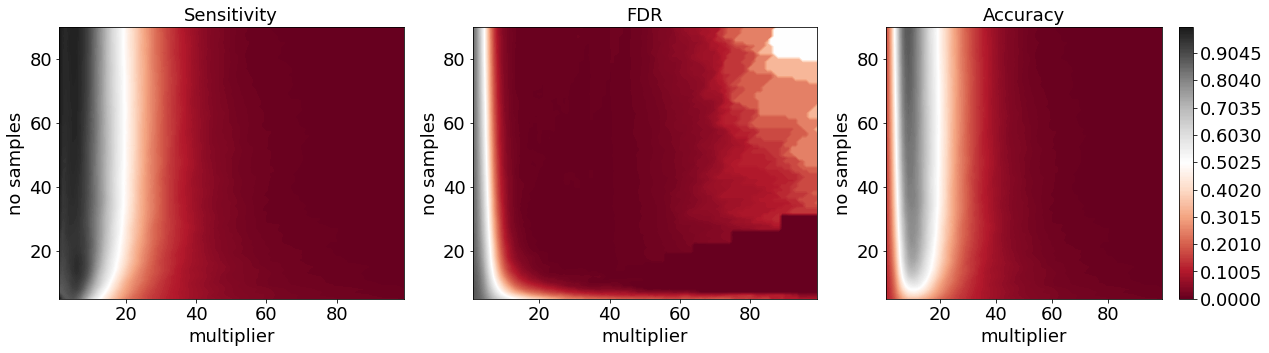

In [22]:
import numpy as np
import cv2 as cv 
import matplotlib.pyplot as plt
import h5py
import math
import os
from scipy import signal

X = np.arange(1,100,1,dtype=int)
Y = np.arange(5,91,1,dtype=int)

# Z_sensitivity = np.array(sensitivity)
# Z_fdr = np.array(fdr)
# Z_accuracy = np.array(accuracy)


SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

filename = "average_590_1200_neo_abs_down_q_02.h5"
# with h5py.File(filename,"w") as result_file:
#     result_file.create_dataset('sensitivity',data=Z_sensitivity)
#     result_file.create_dataset('fdr',data=Z_fdr)
#     result_file.create_dataset('accuracy',data=Z_accuracy)
#     result_file.close()

with h5py.File(filename,'r') as test_read:
    read_sens = test_read['sensitivity'][()] # the raw waveform
    read_fdr = test_read['fdr'][()]
    read_acc = test_read['accuracy'][()] # the spike time points


read_sens = read_sens[:,0:99]  
read_fdr = read_fdr[:,0:99]  
read_acc = read_acc[:,0:99]  
print(read_sens.shape)
fig_con , ax_cont = plt.subplots(1,3)
fig_con.set_size_inches(21,5)
levels = np.linspace(0.0,1.00,200)
cs1 = ax_cont[0].contourf(X, Y, read_sens, levels, cmap='RdGy')
cs2 = ax_cont[1].contourf(X, Y, read_fdr, levels, cmap='RdGy')
cs3 = ax_cont[2].contourf(X, Y, read_acc, levels, cmap='RdGy')
fig_con.colorbar(cs3, ax=ax_cont[2])
ax_cont[0].set_title("Sensitivity")
ax_cont[1].set_title("FDR")
ax_cont[2].set_title("Accuracy")
for i in range(3):
    ax_cont[i].set_xlabel("multiplier")
    ax_cont[i].set_ylabel("no samples")

# fig_con.colorbar(cs2, ax=ax_cont[1])
# fig_con.colorbar(cs3, ax=ax_cont[2])
plt.savefig("average_neo_down_q_02.jpg", bbox_inches='tight', pad_inches=0.1,dpi=300)
plt.show()

In [55]:
spikes_control = spikes_int[0][:]
spikes_control = spikes_control.tolist()
spikes_control = find_max_difference(spikes_control)

sensitivity = [] 
fdr = []
accuracy = []
sensitivity_list = []
fdr_list = []
accuracy_list = []

for i in range(5,91,1):
    print(i)
    output_moving_average_initial = moving_average(data_fneo,i,1.0)
    output_moving_average_initial = np.round(output_moving_average_initial,0)
    output_moving_average_initial = output_moving_average_initial.astype(int)
    for j in range(1,200):
        output_moving_average = output_moving_average_initial * j        
        found_spikes = spike_finder(data_fneo,output_moving_average,15)
        correct_spikes , incorrect_spikes, missed_spikes, found = spike_ratios(found_spikes,spikes_control,10)
        if (correct_spikes + missed_spikes)!=0:
            sensitivity_list.append((correct_spikes/(correct_spikes + missed_spikes)))
        else:
            sensitivity_list.append(0)
        if (correct_spikes + incorrect_spikes)!=0:
            fdr_list.append((incorrect_spikes/(correct_spikes + incorrect_spikes)))
        else:
            fdr_list.append(0)
        if (correct_spikes + incorrect_spikes + missed_spikes)!=0:    
            accuracy_list.append((correct_spikes/(correct_spikes + incorrect_spikes + missed_spikes)))
        else:
            accuracy_list.append(0)    
    sensitivity.append(sensitivity_list)
    fdr.append(fdr_list)
    accuracy.append(accuracy_list)
    sensitivity_list = []
    fdr_list = []
    accuracy_list = []   

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


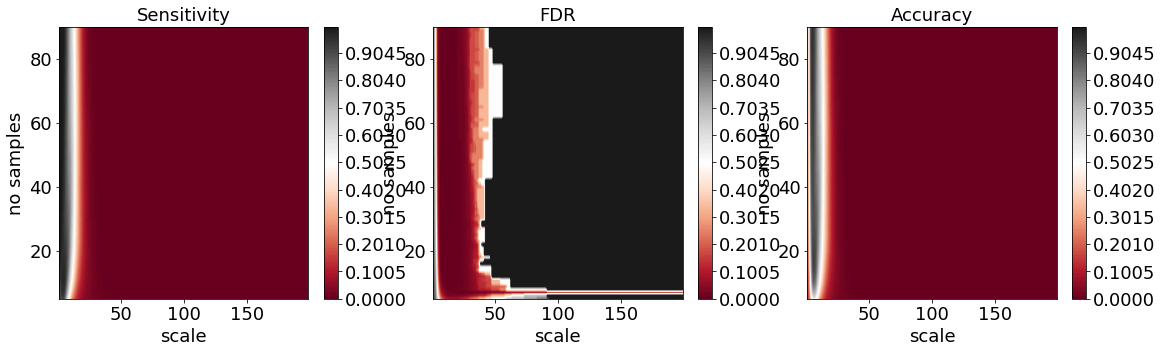

In [56]:
X = np.arange(1,200,1,dtype=int)
Y = np.arange(5,91,1,dtype=int)

Z_sensitivity = np.array(sensitivity)
Z_fdr = np.array(fdr)
Z_accuracy = np.array(accuracy)

filename = "average_590_1200_abs_down_q_005.h5"
with h5py.File(filename,"w") as result_file:
    result_file.create_dataset('sensitivity',data=Z_sensitivity)
    result_file.create_dataset('fdr',data=Z_fdr)
    result_file.create_dataset('accuracy',data=Z_accuracy)
    result_file.close()

# with h5py.File(filename,'r') as test_read:
#     read_sens = test_read['sensitivity'][()] # the raw waveform
#     read_fdr = test_read['fdr'][()]
#     read_acc = test_read['accuracy'][()] # the spike time points
    
fig_con , ax_cont = plt.subplots(1,3)
fig_con.set_size_inches(19,5)
levels = np.linspace(0.0,1.00,200)
cs1 = ax_cont[0].contourf(X, Y, Z_sensitivity, levels, cmap='RdGy')
cs2 = ax_cont[1].contourf(X, Y, Z_fdr, levels, cmap='RdGy')
cs3 = ax_cont[2].contourf(X, Y, Z_accuracy, levels, cmap='RdGy')
fig_con.colorbar(cs1, ax=ax_cont[0])
ax_cont[0].set_title("Sensitivity")
ax_cont[1].set_title("FDR")
ax_cont[2].set_title("Accuracy")
for i in range(3):
    ax_cont[i].set_xlabel("scale")
    ax_cont[i].set_ylabel("no samples")

fig_con.colorbar(cs2, ax=ax_cont[1])
fig_con.colorbar(cs3, ax=ax_cont[2])
plt.savefig("average_abs_down_q_005.jpg")
plt.show()

In [57]:
spikes_control = spikes_int[0][:]
spikes_control = spikes_control.tolist()
spikes_control = find_max_difference(spikes_control)

sensitivity = []
fdr = []
accuracy = []
sensitivity_list = []
fdr_list = []
accuracy_list = []

for i in range(15,91,5):
    print(i)
    output_moving_average_initial = median_of_medians_hard(data_fneo,i)
    output_moving_average_initial = np.round(output_moving_average_initial,0)
    output_moving_average_initial = output_moving_average_initial.astype(int)
    for j in range(1,200): 
        output_moving_average = output_moving_average_initial * j        
        found_spikes = spike_finder(data_fneo,output_moving_average,15)
        correct_spikes , incorrect_spikes, missed_spikes, found = spike_ratios(found_spikes,spikes_control,10)
        if (correct_spikes + missed_spikes)!=0:
            sensitivity_list.append((correct_spikes/(correct_spikes + missed_spikes)))
        else:
            sensitivity_list.append(0)
        if (correct_spikes + incorrect_spikes)!=0:
            fdr_list.append((incorrect_spikes/(correct_spikes + incorrect_spikes)))
        else:
            fdr_list.append(0)
        if (correct_spikes + incorrect_spikes + missed_spikes)!=0:    
            accuracy_list.append((correct_spikes/(correct_spikes + incorrect_spikes + missed_spikes)))
        else:
            accuracy_list.append(0)    
    sensitivity.append(sensitivity_list)
    fdr.append(fdr_list)
    accuracy.append(accuracy_list)
    sensitivity_list = []
    fdr_list = []
    accuracy_list = []   

15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90


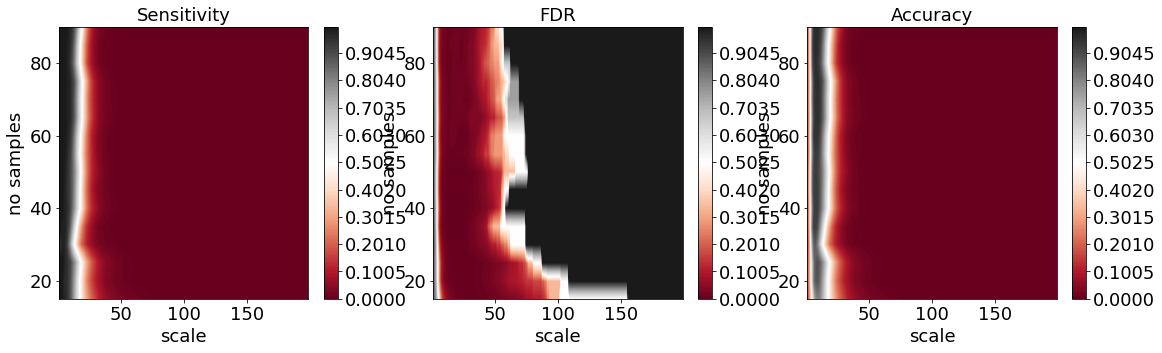

In [58]:
X = np.arange(1,200,1,dtype=int)
Y = np.arange(15,91,5,dtype=int)

Z_sensitivity = np.array(sensitivity)
Z_fdr = np.array(fdr)
Z_accuracy = np.array(accuracy)

filename = "medianmedians5_1590_1200_abs_down_q_005.h5"
with h5py.File(filename,"w") as result_file:
    result_file.create_dataset('sensitivity',data=Z_sensitivity)
    result_file.create_dataset('fdr',data=Z_fdr)
    result_file.create_dataset('accuracy',data=Z_accuracy)
    result_file.close()

# with h5py.File(filename,'r') as test_read:
#     read_sens = test_read['sensitivity'][()] # the raw waveform
#     read_fdr = test_read['fdr'][()]
#     read_acc = test_read['accuracy'][()] # the spike time points
    
fig_con , ax_cont = plt.subplots(1,3)
fig_con.set_size_inches(19,5)
levels = np.linspace(0.0,1.00,200)
cs1 = ax_cont[0].contourf(X, Y, Z_sensitivity, levels, cmap='RdGy')
cs2 = ax_cont[1].contourf(X, Y, Z_fdr, levels, cmap='RdGy')
cs3 = ax_cont[2].contourf(X, Y, Z_accuracy, levels, cmap='RdGy')
fig_con.colorbar(cs1, ax=ax_cont[0])
ax_cont[0].set_title("Sensitivity")
ax_cont[1].set_title("FDR")
ax_cont[2].set_title("Accuracy")
for i in range(3):
    ax_cont[i].set_xlabel("scale")
    ax_cont[i].set_ylabel("no samples")

fig_con.colorbar(cs2, ax=ax_cont[1])
fig_con.colorbar(cs3, ax=ax_cont[2])
plt.savefig("medianmedians_abs_down_q_005.jpg")
plt.show()

In [59]:
with h5py.File('median_medians5_1590_1120_neo_abs_down_q_01.h5','r') as test_read:
    read_sens = test_read['sensitivity'][()] # the raw waveform
    read_fdr = test_read['fdr'][()]
    read_acc = test_read['accuracy'][()] # the spike time points

print(read_acc.shape)
max_acc = np.amax(read_acc)
print(max_acc)
print(np.where(read_acc==max_acc))
print(read_acc[2])

print('asses sens')

print(read_sens.shape)
max_sens = np.amax(read_sens)
print(max_sens)
print(read_sens[2])

(16, 119)
0.9832610043397396
(array([14], dtype=int64), array([32], dtype=int64))
[0.14218878 0.15708076 0.18015938 0.21371451 0.25544092 0.30088072
 0.35541964 0.40925684 0.46635043 0.51964345 0.57098821 0.61743389
 0.66274427 0.70258237 0.74071462 0.77177104 0.80253807 0.82489562
 0.84631861 0.86213486 0.87945434 0.89464741 0.905076   0.9147579
 0.92350528 0.92943608 0.93293769 0.9383787  0.94163658 0.94410876
 0.94515152 0.94648829 0.94724001 0.94646681 0.94337313 0.94355828
 0.94435905 0.94605425 0.94478717 0.94446159 0.94341373 0.94090347
 0.93839009 0.93796526 0.93484331 0.9316133  0.92912652 0.92568408
 0.92312481 0.92120835 0.91931464 0.91705644 0.91606864 0.91323346
 0.91102092 0.90630856 0.90334689 0.89827856 0.89392991 0.88802002
 0.88231612 0.87605634 0.87104851 0.86881653 0.86434837 0.86027569
 0.85553118 0.84863679 0.84514107 0.84070241 0.83500627 0.82716437
 0.82126058 0.81561618 0.81185325 0.80803011 0.80207026 0.79573266
 0.78977094 0.78593848 0.7787194  0.77488226 0.7

In [60]:
with h5py.File('average_590_1200_neo_abs_down_q_01.h5','r') as test_read:
    read_sens = test_read['sensitivity'][()] # the raw waveform
    read_fdr = test_read['fdr'][()]
    read_acc = test_read['accuracy'][()] # the spike time points

print(read_acc.shape)
max_acc = np.amax(read_acc)
print(max_acc)
print(np.where(read_acc==max_acc))
print(read_acc[11])

print('asses sens')

print(read_sens.shape)
max_sens = np.amax(read_sens)
print(max_sens)

print(read_sens[11])

(86, 199)
0.9370586429229352
(array([82], dtype=int64), array([10], dtype=int64))
[0.12407713 0.15344708 0.19822925 0.26766998 0.35907153 0.47077773
 0.57943222 0.68228016 0.76654275 0.8275308  0.86717214 0.89784005
 0.91479821 0.91969697 0.91919192 0.91514965 0.90632754 0.89051322
 0.87480487 0.85347527 0.82988722 0.80721003 0.7815047  0.76028904
 0.73067253 0.70521684 0.68594782 0.66237032 0.63647799 0.61717521
 0.59547027 0.57219251 0.54926031 0.52974504 0.51432169 0.49543595
 0.47623544 0.45609065 0.43846396 0.42618823 0.41328297 0.39565628
 0.38338055 0.36449481 0.34875669 0.33899906 0.32389046 0.31287378
 0.30280138 0.28958137 0.27896725 0.26763224 0.25881612 0.25
 0.23960957 0.2336272  0.22418136 0.21599496 0.21001259 0.2034005
 0.19584383 0.18891688 0.18356423 0.17695214 0.1731738  0.16435768
 0.15806045 0.15302267 0.14924433 0.14357683 0.13948363 0.13350126
 0.1290932  0.12531486 0.11996222 0.1168136  0.11335013 0.10925693
 0.1070529  0.10421914 0.10170025 0.09918136 0.0972921

In [61]:
# use te code below for data from https://zenodo.org/record/583331#.Yg_lU-j7Q2w
# cursor_pos = read_test_file.get('cursor_pos')
# target_pos = read_test_file.get('target_pos')
# finger_pos = read_test_file.get('finger_pos')
# cursor_time = read_test_file.get('t')
# waveform = read_test_file.get('wf')

# cursor_time = np.array(cursor_time)
# cursor_pos = np.array(cursor_pos)
# target_pos = np.array(target_pos)
# finger_pos = np.array(finger_pos)

# with h5py.File(test_filename,'r') as f:
#     spikes = f['spikes'][()] # 5 x C dimension, where C = number of channels
#     spikes = np.transpose(spikes) # transpose to be C x 5 dimension
#     num_chan = spikes.shape[0]
#     num_unit = spikes.shape[1]
#     all_spikes = [] # list 96 channels of list 5 units containing array of num of spikes
#     for i in range(num_chan):
#         chan_spikes = []
#         for j in range(num_unit):
#             if (f[spikes[i,j]].ndim==2):
#                 temp_spikes = np.squeeze(f[spikes[i,j]][()],axis=0) # dimension: num of spikes, remove first dimension axis=0
#             else:
#                 temp_spikes = np.empty(0)
#             chan_spikes.append(temp_spikes)
#         all_spikes.append(chan_spikes)
# #all_spikes = np.array(all_spikes)
# print(all_spikes[1][1].shape)

# index_filename = test_folder+test_file+'_spike_index.h5'
# print ("Loading spike index data into file: "+index_filename)
# with h5py.File(index_filename,'r') as f:
#     sua_idx = f['sua_index'][()]
#     mua_idx = f['mua_index'][()]

# sua_trains = []
# num_sua_trains = []    
# for i in range(num_chan):
#     if (len(sua_idx[i])>0):
#         for j in range(len(sua_idx[i])):
#             idx = sua_idx[i][j]
#             sua_train = all_spikes[i][idx]
#             sua_crop = np.where((sua_train>=cursor_time[0]) & (sua_train<=cursor_time[-1]))[0]
#             sua_train = sua_train[sua_crop]
#             sua_trains.append(sua_train)
#             num_sua_trains.append(len(sua_train))
# num_sua = len(sua_trains) 
# 
#  
